# Examining Behavior of SPX Options on Expiration Day

### 1) Data Cleaning and Preparation
- Consolidate intraday minutely data from daily SPX yahoo pulls
- Consolidate VIX intraday prices from daily VIX options files
- Consolidate 0 DTE expiration options from daily SPX options pulls
- Retrieve live minutely data from Alphavantage

### 2) Initial Check of SPX Spot Behavior Intraday
- Test for random walk
    - Check 1 min, 5 min, 10 min, 15 min, 20 min, 30 min intervals on:
        - Entire day
        - Segmented times in the day, e.g., hourly behavior, half-hour behavior, etc.
    - Perform DF test
    - Calculate probability of price movements using volatility windows and simulating price behavior

### 3) Relationship of VIX Intraday to 0 DTE Option IV
- Check if VIX and IV use calendar or trading days to annualize
    - **IV on the options chain is in calendar years with 24 hour days -> minutes_remaining/(60 x 24 x 365.25)**
- Determine Function of Skew using 3rd and 4th moments
- Plot IV surface against strikes and time of day
- Check behavior of IV movement given VIX term structure is in Contango or Backwardation

### 4) Expiration Day Option Pricing
- Implied Binomial Pricing model using probability inferred from option prices
- Monte Carlo using implied binomial probabilities then backing out he IV from simulated option prices
- Use Black Scholes but IV based on VIX intraday or HV from intraday SPX
- **Track the IV live on the option chain in IB and use BS to calculate the delta to confirm validity**

##### Importing Necessary Modules

In [705]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import pandas.stats.moments as st
import statsmodels.tsa.stattools as ts
from pandas_datareader.data import Options
pd.options.display.float_format = '{:,.4f}'.format

import numpy as np
import datetime as dt
import time

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
%matplotlib inline

from sqlalchemy import *
from sqlalchemy import create_engine
import sqlite3 as sql
from scipy.stats import norm as norm

import py_vollib.black.greeks.analytical as py_greeks
import py_vollib.ref_python.black_scholes as py_bs
import os
main_dir = os.getcwd()
os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Trading\\Modules\\RetiredModules')
from helpers import maturities
os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Trading\\Modules\\DataCollection')
cleaned_dir = 'D:\\Options Data\\Monthly DBs'
from yahoo_query import *

def alpha_vantage(ticker, key):
    if key == 0:
        api_key = '5HZEUI5AFJB06BUK'
    else:
        api_key = '6ZAZOL7YF8VPXND7'
    url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={0}&interval=1min&outputsize=full&apikey={1}&datatype=csv' 
    df = pd.read_csv(url.format(ticker, api_key), index_col = 0).sort_index()
    df.index = pd.to_datetime(df.index)    
    return df

from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
from statsmodels.graphics.tsaplots import plot_acf

def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, len(ts) - 1)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

def hurst_ernie_chan(p):

    variancetau = []; tau = []
    lags = range(2, len(p) - 1)
    
    for lag in lags: 

        #  Write the different lags into a vector to compute a set of tau or lags
        tau.append(lag)

        # Compute the log returns on all days, then compute the variance on the difference in log returns
        # call this pp or the price difference
        pp = subtract(p[lag:], p[:-lag])
        variancetau.append(np.var(pp))

    # we now have a set of tau or lags and a corresponding set of variances.
    #print tau
    #print variancetau

    # plot the log of those variance against the log of tau and get the slope
    m = polyfit(np.log10(tau),np.log10(variancetau),1)

    hurst = m[0] / 2

    return hurst

##### 1) Data Preparation

In [125]:
# Retrieving Data for VIX Term Structure
v1 = pd.read_csv('https://www.quandl.com/api/v3/datasets/CHRIS/CBOE_VX1.csv?api_key=dzmzEExntfap7SNx5p6t', index_col = 0)[['Open','Close']].sort_index()
v2 = pd.read_csv('https://www.quandl.com/api/v3/datasets/CHRIS/CBOE_VX2.csv?api_key=dzmzEExntfap7SNx5p6t', index_col = 0)[['Open','Close']].sort_index()
vix = pd.read_csv('http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vixcurrent.csv', skiprows=[0], index_col = 0)
vix.index = pd.to_datetime(vix.index)
vix_term = vix.join(v1.join(v2, lsuffix = '_F1', rsuffix = '_F2').dropna()).dropna()
vix_term['Front_Weights'] = np.nan
vix_term['Back_Weights'] = np.nan

for index, row in vix_term.iterrows():
    weights = maturities(index.date())
    front_weight = weights[0]
    back_weight = weights[1]
    vix_term.loc[index, 'Front_Weights'] = front_weight
    vix_term.loc[index, 'Back_Weights'] = back_weight
    
vix_term = vix_term[list(filter(lambda x: 'Open' in x or 'Weight' in x, vix_term.columns.tolist()))]
vix_term['Contango_Ratio'] = vix_term.Front_Weights*(vix_term['VIX Open']/vix_term.Open_F1) + vix_term.Back_Weights*(vix_term.Open_F1/vix_term.Open_F2)
vix_term = vix_term[vix_term.index >= dt.datetime(2018,7,30)]

# Retrieving Data For Intraday SPX and VIX Indices from Local Databases
os.chdir(cleaned_dir)
vix_intraday = pd.read_csv('vix_intraday.csv', index_col = 0).set_index('Quote_Time')
vix_intraday.index = pd.to_datetime(vix_intraday.index)
vix_intraday = vix_intraday[~vix_intraday.index.duplicated(keep='last')].sort_index()

spx_intraday = []
calls_intraday = []
puts_intraday = []

for curr_date in [dt.datetime(2018,x,1) for x in range(7,13)] + [dt.datetime(2019,1,1)]:
    db_name = 'sqlite:///intraday_{0}-{1}.db'.format(curr_date.year,curr_date.month)
    options_engine = create_engine(db_name, echo=False)
    latest_spx = pd.read_sql_query('SELECT * FROM spx_prices', con = options_engine, index_col = 'index')
    latest_spx.index = pd.to_datetime(latest_spx.index)
    spx_intraday.append(latest_spx)
    
    options_query = 'SELECT * FROM spx_{} WHERE DTE = 0'
    
    latest_calls = pd.read_sql_query(options_query.format('calls'), con = options_engine, index_col = 'quoteTime')
    latest_calls.index = pd.to_datetime(latest_calls.index)
    calls_intraday.append(latest_calls)
    
    latest_puts = pd.read_sql_query(options_query.format('puts'), con = options_engine, index_col = 'quoteTime')
    latest_puts.index = pd.to_datetime(latest_puts.index)
    puts_intraday.append(latest_puts)
    
spx_intraday = pd.concat(spx_intraday, axis = 0)
spx_intraday['Date'] = spx_intraday.index.date
calls_intraday = pd.concat(calls_intraday, axis = 0)
puts_intraday = pd.concat(puts_intraday, axis = 0)

# Cleaning SPX Intraday Data
exclusions = spx_intraday.groupby('Date').count()
exclusions = exclusions.reset_index()

exclusion_dates = exclusions[(exclusions['Last'] <= 350) | (exclusions.Last > 391)].Date.tolist()
spx_intraday = spx_intraday[spx_intraday.Date.isin(exclusion_dates) == False]

impute_dates = exclusions[(exclusions.Last != 391) & (exclusions.Date.isin(exclusion_dates) == False)]

model_day = spx_intraday[spx_intraday.Date == dt.date(2018,7,31)].copy()

corrected_df_list = []

for date_to_correct in impute_dates.Date:
    df_to_correct = spx_intraday[spx_intraday.Date == date_to_correct].copy()
    time_delta_adj = df_to_correct.Date.head(1).values[0] - model_day.Date.head(1).values[0]
    
    df_to_join = model_day.copy()
    df_to_join.index = df_to_join.index + time_delta_adj
    del df_to_join['Last'], df_to_join['Date']
    
    df_to_correct = df_to_join.join(df_to_correct)
    df_to_correct.Date = df_to_correct.index.date
    df_to_correct = df_to_correct.fillna(method = 'bfill')
    
    corrected_df_list.append(df_to_correct)
    
corrected_spx_df = pd.concat(corrected_df_list, axis = 0)
spx_intraday = pd.concat([spx_intraday[spx_intraday.Date.isin(impute_dates.Date.tolist()) == False],
                          corrected_spx_df], axis = 0).sort_index()

further_exclusion_dates = [dt.date(2018,10,10), dt.date(2018,9,3), dt.date(2018,12,24),
                           dt.date(2018,12,25)]

spx_intraday = spx_intraday[spx_intraday.Date.isin(further_exclusion_dates) == False]

tol = pd.Timedelta('180 second')
index_intraday = pd.merge_asof(left=spx_intraday,right=vix_intraday[['Underlying_Price']],
                               right_index=True,
                               left_index=True,
                               direction='nearest',
                               tolerance=tol).dropna()
index_intraday.columns = ['SPX','Date','VIX']

##### 2) Initial Check of SPX Spot Behavior Intraday
- Test for random walk
    - Check 1 min, 5 min intervals on:
        - Entire day
        - Segmented times in the day, e.g., hourly behavior, half-hour behavior, etc.
    - Perform DF test
    - Calculate probability of price movements using volatility windows and simulating price behavior

**ADF test for random walk** <br>
- The test statistic is a negative number and thus in order to be significant beyond the critical values, the number must be more negative than these values, i.e. less than the critical values.
- The ADF null hypothesis is that the process is a random walk and thus non mean-reverting (i.e., a high p-value indicates that we fail to reject the null that it is a random walk)
- The output of the Augmented Dickey-Fuller test over a period is as follows:
    - The first value is the calculated test-statistic
    - The second value is the p-value.
    - The fourth is the number of data points in the sample. 
    - The fifth value, the dictionary, contains the critical values of the test-statistic at the 1, 5 and 10 percent values respectively.

**Hurst Exponent Test for Stationarity** <br>
A time series can then be characterised in the following manner:
- H < 0.5 - The time series is mean reverting
- H = 0.5 - The time series is a Geometric Brownian Motion
- H > 0.5 - The time series is trending

**Autocorrelation is highest most often during the times of 9:30 AM to 10:00 AM and 1:00 PM to 2:00 PM** <br>
**Non-mean reverting series occurs most often at 9:30 AM to 10:00 AM and from 1:00 PM to 3:00 PM**

In [431]:
def intraday_autocorr(price_series, curr_date):
    
    day_blocks = [dt.datetime(curr_date.year, curr_date.month, curr_date.day, x) for x in range(9,17)]
    day_blocks = [day_blocks[i:i + 2] for i in range(len(day_blocks) - 1)]
    block_series = [price_series[(price_series.index >= block[0]) & 
                                 (price_series.index <= block[1])] for block in day_blocks]
    
    return [price_series.Last.pct_change().dropna().autocorr()] + [block.Last.pct_change().dropna().autocorr() for block in block_series]

def intraday_ts_tests(price_series, curr_date, use_5min = False):
    
    day_blocks = [dt.datetime(curr_date.year, curr_date.month, curr_date.day, x) for x in range(9,17)]
    day_blocks = [day_blocks[i:i + 2] for i in range(len(day_blocks) - 1)]
    block_series = [price_series[(price_series.index >= block[0]) & 
                                 (price_series.index <= block[1])] for block in day_blocks]
    if use_5min:
        block_series[0] = price_series[(price_series.index <= dt.datetime(curr_date.year,
                                                                          curr_date.month, 
                                                                          curr_date.day, 10, 30))]

    return [(ts.adfuller(price_series.Last)[1], 
             hurst_ernie_chan(price_series.Last))] + [(ts.adfuller(block.Last)[1], 
                                            hurst_ernie_chan(block.Last)) for block in block_series]

def create_stats_df(interval_dict):
    for i, k in enumerate(interval_dict.keys()):
        if i == 0:
            curr_interval_df = pd.DataFrame(interval_dict[k], index = spx_intraday.Date.drop_duplicates())
        else:
            curr_interval_df = curr_interval_df.join(pd.DataFrame(interval_dict[k], index = spx_intraday.Date.drop_duplicates()),
                                                     rsuffix = '_{}'.format(k))

    return curr_interval_df

intervals_1min = {'full_day': {'hurst':[],'adf':[]}, 'timeblock1': {'hurst':[],'adf':[]},
                  'timeblock2': {'hurst':[],'adf':[]}, 'timeblock3': {'hurst':[],'adf':[]},
                  'timeblock4': {'hurst':[],'adf':[]}, 'timeblock5': {'hurst':[],'adf':[]},
                  'timeblock6': {'hurst':[],'adf':[]}}
intervals_5min = {'full_day': {'hurst':[],'adf':[]}, 'timeblock1': {'hurst':[],'adf':[]},
                  'timeblock2': {'hurst':[],'adf':[]}, 'timeblock3': {'hurst':[],'adf':[]},
                  'timeblock4': {'hurst':[],'adf':[]}, 'timeblock5': {'hurst':[],'adf':[]},
                  'timeblock6': {'hurst':[],'adf':[]}}

for curr_date in spx_intraday.Date.drop_duplicates().tolist():

    curr_day_spx = spx_intraday[spx_intraday.Date == curr_date][['Last']]
    curr_5min = curr_day_spx.iloc[::5, :]    
    
    curr_1min_tests = intraday_ts_tests(curr_day_spx, curr_date)
    curr_5min_tests = intraday_ts_tests(curr_5min, curr_date, True)
    
    i = 0
    for k,v in intervals_1min.items():
        intervals_1min[k]['hurst'].append(curr_1min_tests[i][1])
        intervals_1min[k]['adf'].append(curr_1min_tests[i][0])

        i += 1
        
    i = 0
    for k,v in intervals_5min.items():
        intervals_5min[k]['hurst'].append(curr_5min_tests[i][1])
        intervals_5min[k]['adf'].append(curr_5min_tests[i][0])

        i += 1
        
intervals_1min = create_stats_df(intervals_1min)
intervals_5min = create_stats_df(intervals_5min)

In [382]:
adfs_1min = intervals_1min[list(filter(lambda x: 'adf' in x, intervals_1min.columns.tolist()))]
adfs_5min = intervals_5min[list(filter(lambda x: 'adf' in x, intervals_5min.columns.tolist()))]

hurst_1min = intervals_1min[list(filter(lambda x: 'hurst' in x, intervals_1min.columns.tolist()))]
hurst_5min = intervals_5min[list(filter(lambda x: 'hurst' in x, intervals_5min.columns.tolist()))]

idx = ['full_day', 'timeblock1', 'timeblock2', 'timeblock3','timeblock4', 'timeblock5', 'timeblock6']

adf_summary = {'adf_1min':[],
                 'adf_5min':[]}

for col in adfs_1min.columns:
    adf_summary['adf_1min'].append(len(adfs_1min[adfs_1min[col] < 0.05]))
    adf_summary['adf_5min'].append(len(adfs_5min[adfs_5min[col] < 0.05]))

In [391]:
day_blocks = [dt.datetime(curr_date.year, curr_date.month, curr_date.day, x) for x in range(9,17)]
day_blocks = [day_blocks[i:i + 2] for i in range(len(day_blocks) - 1)]
time_blocks = [str([x.strftime('%H:%M') for x in block]).replace('[','').replace(']','').replace("'",'') for block in day_blocks]

hurst_1min_summary = {'mr_counts':[],
                      'gbm_counts':[],
                      'trend_counts':[]}

hurst_5min_summary = {'mr_counts':[],
                      'gbm_counts':[],
                      'trend_counts':[]}

for col in hurst_1min.columns:
    hurst_1min_summary['mr_counts'].append(len(hurst_1min[hurst_1min[col] < 0.4]))
    hurst_1min_summary['trend_counts'].append(len(hurst_1min[hurst_1min[col] > 0.6]))
    hurst_1min_summary['gbm_counts'].append(len(hurst_1min[(hurst_1min[col] <= 0.6) & (hurst_1min[col] >= 0.4)]))
    
for col in hurst_5min.columns:
    hurst_5min_summary['mr_counts'].append(len(hurst_5min[hurst_5min[col] < 0.4]))
    hurst_5min_summary['trend_counts'].append(len(hurst_5min[hurst_5min[col] > 0.6]))
    hurst_5min_summary['gbm_counts'].append(len(hurst_5min[(hurst_5min[col] <= 0.6) & (hurst_5min[col] >= 0.4)]))

pd.DataFrame(adf_summary,index = idx).join(pd.DataFrame(hurst_1min_summary,index = idx),
                                           rsuffix = '_hurst1').join(pd.DataFrame(hurst_5min_summary,index = idx),
                                                                     rsuffix = '_hurst5')

adf_1min  adf_5min  gbm_counts  mr_counts  trend_counts  \
full_day          12        12           0        108             0   
timeblock1        17         9           0        107             0   
timeblock2         7         3           0        107             0   
timeblock3         8         6           0        107             0   
timeblock4        12         3           0        108             0   
timeblock5        12        13           0        108             0   
timeblock6         5         7           0        107             0   

            gbm_counts_hurst5  mr_counts_hurst5  trend_counts_hurst5  
full_day                    0               108                    0  
timeblock1                  1               107                    0  
timeblock2                  0               107                    0  
timeblock3                  0               108                    0  
timeblock4                  0               108                    0  
timeblock5                  0               108                    0  
timeblock6                  0               107                    0

In [432]:
autocorr_idx = idx + ['timeblock7']

intervals_1min_autocorr = {k:[] for k in autocorr_idx}
intervals_5min_autocorr = {k:[] for k in autocorr_idx}

for curr_date in spx_intraday.Date.drop_duplicates().tolist():

    curr_day_spx = spx_intraday[spx_intraday.Date == curr_date][['Last']]
    curr_5min = curr_day_spx.iloc[::5, :]    

    autocorrs_1min = intraday_autocorr(curr_day_spx, curr_date)
    autocorrs_5min = intraday_autocorr(curr_5min, curr_date)
    
    for i,v in enumerate(autocorrs_1min):
        intervals_1min_autocorr[autocorr_idx[i]].append(v)
    
    for i,v in enumerate(autocorrs_5min):
        intervals_5min_autocorr[autocorr_idx[i]].append(v)

intervals_1min_autocorr = pd.DataFrame(intervals_1min_autocorr, index = spx_intraday.Date.drop_duplicates().tolist())
intervals_5min_autocorr = pd.DataFrame(intervals_5min_autocorr, index = spx_intraday.Date.drop_duplicates().tolist())

In [450]:
autocorr_1min_summary = {k:[] for k in intervals_1min_autocorr.columns}
autocorr_5min_summary = {k:[] for k in intervals_5min_autocorr.columns}

for col in intervals_1min_autocorr.columns:
    autocorr_1min_summary[col].append(len(intervals_1min_autocorr[abs(intervals_1min_autocorr[col]) > 0.3]))
    autocorr_5min_summary[col].append(len(intervals_5min_autocorr[abs(intervals_5min_autocorr[col]) > 0.3]))

In [451]:
pd.DataFrame(autocorr_1min_summary, 
             index = ['interval_1min']).T.join(pd.DataFrame(autocorr_5min_summary,
                                                            index = ['interval_5min']).T)

interval_1min  interval_5min
full_day                0              0
timeblock1             11             67
timeblock2              3             28
timeblock3              2             40
timeblock4              2             25
timeblock5              2             27
timeblock6              3             30
timeblock7              4             37

In [823]:
token = 0

spx = alpha_vantage('SPX',token)
vix = alpha_vantage('VIX',token)

In [824]:
for i in range(20, len(spx[spx.index >= dt.datetime(max(spx.index).year,max(spx.index).month,max(spx.index).day)]), 20):
    print('Lookback {} Periods:'.format(i))
    print('ADF:')
    print(ts.adfuller(spx.close.tail(i)))
    print('Hurst:')
    print(hurst_ernie_chan(spx.close.tail(i)))
    print('Autocorr:')
    print(spx.close.tail(i).pct_change().autocorr())
    print('')

Lookback 20 Periods:
ADF:
(0.75186259062821115, 0.99081803152845338, 8, 11, {'1%': -4.2232382794891059, '5%': -3.189368925619835, '10%': -2.7298394214876032}, -540.02609043462735)
Hurst:
-0.651417385088
Autocorr:
0.438911713297

Lookback 40 Periods:
ADF:
(-1.0017836231254942, 0.75261320986674185, 1, 38, {'1%': -3.6155091011809297, '5%': -2.9412623574865142, '10%': -2.6091995013850418}, 66.965820434206904)
Hurst:
-0.453891153765
Autocorr:
0.320001685357

Lookback 60 Periods:
ADF:
(-0.99485619058688424, 0.75513576097632495, 3, 56, {'1%': -3.5529282035805392, '5%': -2.9147306250000002, '10%': -2.5951371556122451}, 98.085486984627693)
Hurst:
-0.256191593517
Autocorr:
0.266751888256

Lookback 80 Periods:
ADF:
(-0.66679269810365605, 0.85516452709118806, 3, 76, {'1%': -3.5194805351545413, '5%': -2.9003945086747343, '10%': -2.5874984279778395}, 128.08841564461608)
Hurst:
-0.0515319622067
Autocorr:
0.284500903255

Lookback 100 Periods:
ADF:
(-1.3002170315375501, 0.62907301563969265, 1, 98, {'1%

In [825]:
curr_vix = vix[vix.index >= dt.datetime(max(vix.index).year,max(vix.index).month,max(vix.index).day)][['close']]
close_time = dt.datetime(curr_vix.index[0].year,curr_vix.index[0].month,curr_vix.index[0].day,
                         16)
curr_vix['TimeToExpiration'] = (close_time - curr_vix.index).seconds/60/390
curr_vix['Calendar'] = 365/curr_vix['TimeToExpiration']
curr_vix['Trading'] = 252/curr_vix['TimeToExpiration']
curr_vix['Calendar'] = curr_vix['close']/np.sqrt(curr_vix['Calendar'])/100
curr_vix['Trading'] = curr_vix['close']/np.sqrt(curr_vix['Trading'])/100
curr_vix = curr_vix.join(spx.close, how = 'left', rsuffix = '_spx')
# curr_vix['CalendarUB'] = curr_vix.close_spx*(1 + curr_vix.Calendar)
# curr_vix['CalendarLB'] = curr_vix.close_spx*(1 - curr_vix.Calendar)
curr_vix['TradingUB'] = curr_vix.close_spx*(1 + curr_vix.Trading)
curr_vix['TradingLB'] = curr_vix.close_spx*(1 - curr_vix.Trading)
curr_vix.tail(50)

close  TimeToExpiration  Calendar  Trading  close_spx  \
timestamp                                                                     
2019-01-16 14:43:00 18.3400            0.1974    0.0043   0.0051 2,624.7200   
2019-01-16 14:44:00 18.3600            0.1949    0.0042   0.0051 2,624.3000   
2019-01-16 14:45:00 18.3700            0.1923    0.0042   0.0051 2,623.8601   
2019-01-16 14:46:00 18.3700            0.1897    0.0042   0.0050 2,623.9600   
2019-01-16 14:47:00 18.3900            0.1872    0.0042   0.0050 2,623.8101   
2019-01-16 14:48:00 18.4100            0.1846    0.0041   0.0050 2,623.4399   
2019-01-16 14:49:00 18.4000            0.1821    0.0041   0.0049 2,623.6101   
2019-01-16 14:50:00 18.3700            0.1795    0.0041   0.0049 2,623.7400   
2019-01-16 14:51:00 18.3600            0.1769    0.0040   0.0049 2,624.0000   
2019-01-16 14:52:00 18.3500            0.1744    0.0040   0.0048 2,624.2700   
2019-01-16 14:53:00 18.3600            0.1718    0.0040   0.0048 2,623.9099   
2019-01-16 14:54:00 18.4200            0.1692    0.0040   0.0048 2,622.2900   
2019-01-16 14:55:00 18.4400            0.1667    0.0039   0.0047 2,621.4900   
2019-01-16 14:56:00 18.4500            0.1641    0.0039   0.0047 2,622.1101   
2019-01-16 14:57:00 18.4600            0.1615    0.0039   0.0047 2,621.9700   
2019-01-16 14:58:00 18.4900            0.1590    0.0039   0.0046 2,621.4900   
2019-01-16 14:59:00 18.5200            0.1564    0.0038   0.0046 2,621.1101   
2019-01-16 15:00:00 18.5100            0.1538    0.0038   0.0046 2,621.0801   
2019-01-16 15:01:00 18.5000            0.1513    0.0038   0.0045 2,620.8999   
2019-01-16 15:02:00 18.4800            0.1487    0.0037   0.0045 2,621.5200   
2019-01-16 15:03:00 18.4500            0.1462    0.0037   0.0044 2,622.2400   
2019-01-16 15:04:00 18.4500            0.1436    0.0037   0.0044 2,622.7500   
2019-01-16 15:05:00 18.3900            0.1410    0.0036   0.0044 2,624.0701   
2019-01-16 15:06:00 18.4100            0.1385    0.0036   0.0043 2,623.4800   
2019-01-16 15:07:00 18.4000            0.1359    0.0036   0.0043 2,623.7900   
2019-01-16 15:08:00 18.4100            0.1333    0.0035   0.0042 2,622.6799   
2019-01-16 15:09:00 18.4300            0.1308    0.0035   0.0042 2,622.8899   
2019-01-16 15:10:00 18.4200            0.1282    0.0035   0.0042 2,622.6101   
2019-01-16 15:11:00 18.4200            0.1256    0.0034   0.0041 2,623.0901   
2019-01-16 15:12:00 18.4000            0.1231    0.0034   0.0041 2,623.0400   
2019-01-16 15:13:00 18.4100            0.1205    0.0033   0.0040 2,622.8601   
2019-01-16 15:14:00 18.4300            0.1179    0.0033   0.0040 2,622.4900   
2019-01-16 15:15:00 18.4500            0.1154    0.0033   0.0039 2,621.6299   
2019-01-16 15:16:00 18.4800            0.1128    0.0032   0.0039 2,621.4600   
2019-01-16 15:17:00 18.4500            0.1103    0.0032   0.0039 2,621.6899   
2019-01-16 15:18:00 18.4500            0.1077    0.0032   0.0038 2,621.9299   
2019-01-16 15:19:00 18.4100            0.1051    0.0031   0.0038 2,622.7300   
2019-01-16 15:20:00 18.3700            0.1026    0.0031   0.0037 2,623.3000   
2019-01-16 15:21:00 18.3700            0.1000    0.0030   0.0037 2,623.5000   
2019-01-16 15:22:00 18.3700            0.0974    0.0030   0.0036 2,623.4600   
2019-01-16 15:23:00 18.3200            0.0949    0.0030   0.0036 2,624.3601   
2019-01-16 15:24:00 18.3400            0.0923    0.0029   0.0035 2,623.6799   
2019-01-16 15:25:00 18.3500            0.0897    0.0029   0.0035 2,623.8301   
2019-01-16 15:26:00 18.3500            0.0872    0.0028   0.0034 2,622.6299   
2019-01-16 15:27:00 18.3800            0.0846    0.0028   0.0034 2,623.0901   
2019-01-16 15:28:00 18.3700            0.0821    0.0028   0.0033 2,623.2900   
2019-01-16 15:29:00 18.3400            0.0795    0.0027   0.0033 2,623.7000   
2019-01-16 15:30:00 18.3500            0.0769    0.0027   0.0032 2,623.6001   
2019-01-16 15:31:00 18.3300            0.0744    0.0026   0.0031 2,623.1

In [831]:
curr_spx = spx[spx.index >= dt.datetime(max(spx.index).year,max(spx.index).month,max(spx.index).day)][['close']]
close_time = dt.datetime(curr_spx.index[0].year,curr_spx.index[0].month,curr_spx.index[0].day,
                         16)
curr_spx['TimeToExpiration'] = (close_time - curr_spx.index).seconds/60/390
curr_spx['VIX'] = 18.67
curr_spx['Calendar'] = 365/curr_spx['TimeToExpiration']
curr_spx['Trading'] = 252/curr_spx['TimeToExpiration']
curr_spx['Calendar'] = curr_spx['VIX']/np.sqrt(curr_spx['Calendar'])/100
curr_spx['Trading'] = curr_spx['VIX']/np.sqrt(curr_spx['Trading'])/100
curr_spx['TradingUB'] = curr_spx.close*(1 + curr_spx.Trading)
curr_spx['TradingLB'] = curr_spx.close*(1 - curr_spx.Trading)
curr_spx

close  TimeToExpiration     VIX  Calendar  Trading  \
timestamp                                                                     
2019-01-16 09:31:00 2,614.7900            0.9974 18.6700    0.0098   0.0117   
2019-01-16 09:32:00 2,615.7000            0.9949 18.6700    0.0097   0.0117   
2019-01-16 09:33:00 2,616.3601            0.9923 18.6700    0.0097   0.0117   
2019-01-16 09:34:00 2,616.5000            0.9897 18.6700    0.0097   0.0117   
2019-01-16 09:35:00 2,617.5100            0.9872 18.6700    0.0097   0.0117   
2019-01-16 09:36:00 2,618.0200            0.9846 18.6700    0.0097   0.0117   
2019-01-16 09:37:00 2,617.5701            0.9821 18.6700    0.0097   0.0117   
2019-01-16 09:38:00 2,618.6001            0.9795 18.6700    0.0097   0.0116   
2019-01-16 09:39:00 2,619.0801            0.9769 18.6700    0.0097   0.0116   
2019-01-16 09:40:00 2,618.5200            0.9744 18.6700    0.0096   0.0116   
2019-01-16 09:41:00 2,618.1001            0.9718 18.6700    0.0096   0.0116   
2019-01-16 09:42:00 2,618.9299            0.9692 18.6700    0.0096   0.0116   
2019-01-16 09:43:00 2,618.7900            0.9667 18.6700    0.0096   0.0116   
2019-01-16 09:44:00 2,619.0300            0.9641 18.6700    0.0096   0.0115   
2019-01-16 09:45:00 2,619.3899            0.9615 18.6700    0.0096   0.0115   
2019-01-16 09:46:00 2,620.1001            0.9590 18.6700    0.0096   0.0115   
2019-01-16 09:47:00 2,620.3999            0.9564 18.6700    0.0096   0.0115   
2019-01-16 09:48:00 2,621.9299            0.9538 18.6700    0.0095   0.0115   
2019-01-16 09:49:00 2,622.0200            0.9513 18.6700    0.0095   0.0115   
2019-01-16 09:50:00 2,621.1399            0.9487 18.6700    0.0095   0.0115   
2019-01-16 09:51:00 2,620.8899            0.9462 18.6700    0.0095   0.0114   
2019-01-16 09:52:00 2,620.4099            0.9436 18.6700    0.0095   0.0114   
2019-01-16 09:53:00 2,620.4399            0.9410 18.6700    0.0095   0.0114   
2019-01-16 09:54:00 2,620.3799            0.9385 18.6700    0.0095   0.0114   
2019-01-16 09:55:00 2,620.4399            0.9359 18.6700    0.0095   0.0114   
2019-01-16 09:56:00 2,620.8799            0.9333 18.6700    0.0094   0.0114   
2019-01-16 09:57:00 2,620.9900            0.9308 18.6700    0.0094   0.0113   
2019-01-16 09:58:00 2,621.0801            0.9282 18.6700    0.0094   0.0113   
2019-01-16 09:59:00 2,621.2000            0.9256 18.6700    0.0094   0.0113   
2019-01-16 10:00:00 2,620.9500            0.9231 18.6700    0.0094   0.0113   
...                        ...               ...     ...       ...      ...   
2019-01-16 15:18:00 2,621.9299            0.1077 18.6700    0.0032   0.0039   
2019-01-16 15:19:00 2,622.7300            0.1051 18.6700    0.0032   0.0038   
2019-01-16 15:20:00 2,623.3000            0.1026 18.6700    0.0031   0.0038   
2019-01-16 15:21:00 2,623.5000            0.1000 18.6700    0.0031   0.0037   
2019-01-16 15:22:00 2,623.4600            0.0974 18.6700    0.0031   0.0037   
2019-01-16 15:23:00 2,624.3601            0.0949 18.6700    0.0030   0.0036   
2019-01-16 15:24:00 2,623.6799            0.0923 18.6700    0.0030   0.0036   
2019-01-16 15:25:00 2,623.8301            0.0897 18.6700    0.0029   0.0035   
2019-01-16 15:26:00 2,622.6299            0.0872 18.6700    0.0029   0.0035   
2019-01-16 15:27:00 2,623.0901            0.0846 18.6700    0.0028   0.0034   
2019-01-16 15:28:00 2,623.2900            0.0821 18.6700    0.0028   0.0034   
2019-01-16 15:29:00 2,623.7000            0.0795 18.6700    0.0028   0.0033   
2019-01-16 15:30:00 2,623.6001            0.0769 18.6700    0.0027   0.0033   
2019-01-16 15:31:00 2,623.1101            0.0744 18.6700    0.0027   0.0032   
2019-01-16 15:32:00 2,622.2200            0.0718 18.6700    0.0026   0.0032   
2019-01-16 15:33:00 2,620.4500            0.0692 18.6700    0.0026   0.0031   
2019-01-16 15:34:00 2,618.7700            0.0667 18.6700    0.0025   0.0030   
2019-01-16 15:35:00 2,617.8501            0.0641 18.6700    0.0025   0.0030

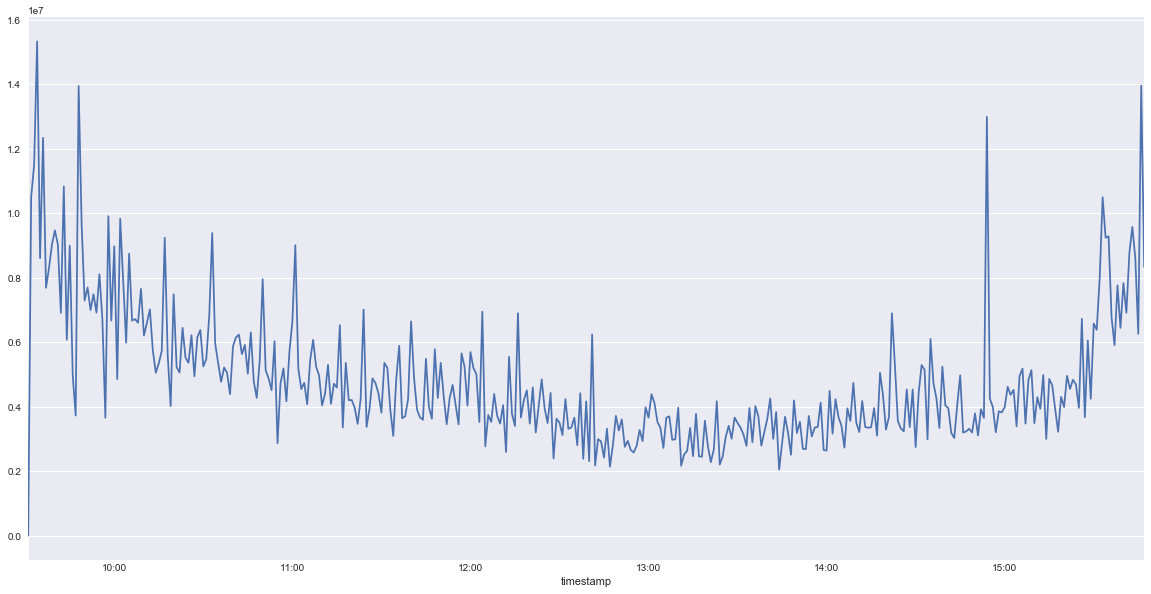

In [827]:
spx[spx.index >= dt.datetime(max(spx.index).year,max(spx.index).month,max(spx.index).day)].volume.plot(figsize = (20,10))

In [828]:
strike_pick = pd.DataFrame({'Strike': list(range(2550,2655,5))})
strike_pick['Return'] = strike_pick.Strike/2607.7 - 1
strike_pick['ImpliedReturn'] = 18.34/np.sqrt(252)/100
strike_pick

Strike  Return  ImpliedReturn
0     2550 -0.0221         0.0116
1     2555 -0.0202         0.0116
2     2560 -0.0183         0.0116
3     2565 -0.0164         0.0116
4     2570 -0.0145         0.0116
5     2575 -0.0125         0.0116
6     2580 -0.0106         0.0116
7     2585 -0.0087         0.0116
8     2590 -0.0068         0.0116
9     2595 -0.0049         0.0116
10    2600 -0.0030         0.0116
11    2605 -0.0010         0.0116
12    2610  0.0009         0.0116
13    2615  0.0028         0.0116
14    2620  0.0047         0.0116
15    2625  0.0066         0.0116
16    2630  0.0086         0.0116
17    2635  0.0105         0.0116
18    2640  0.0124         0.0116
19    2645  0.0143         0.0116
20    2650  0.0162         0.0116

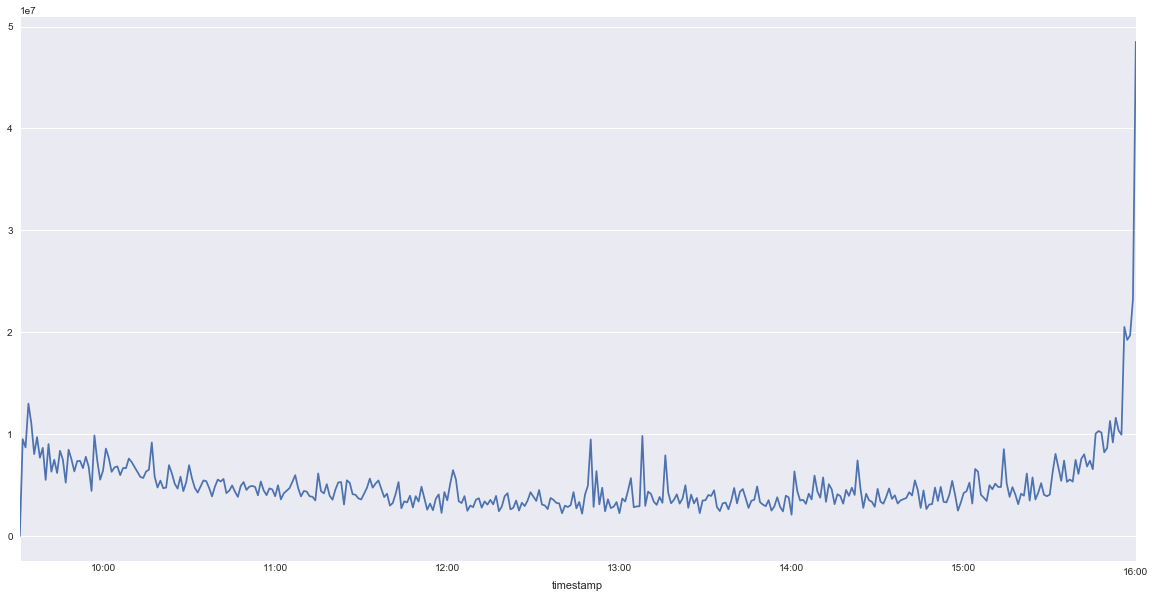

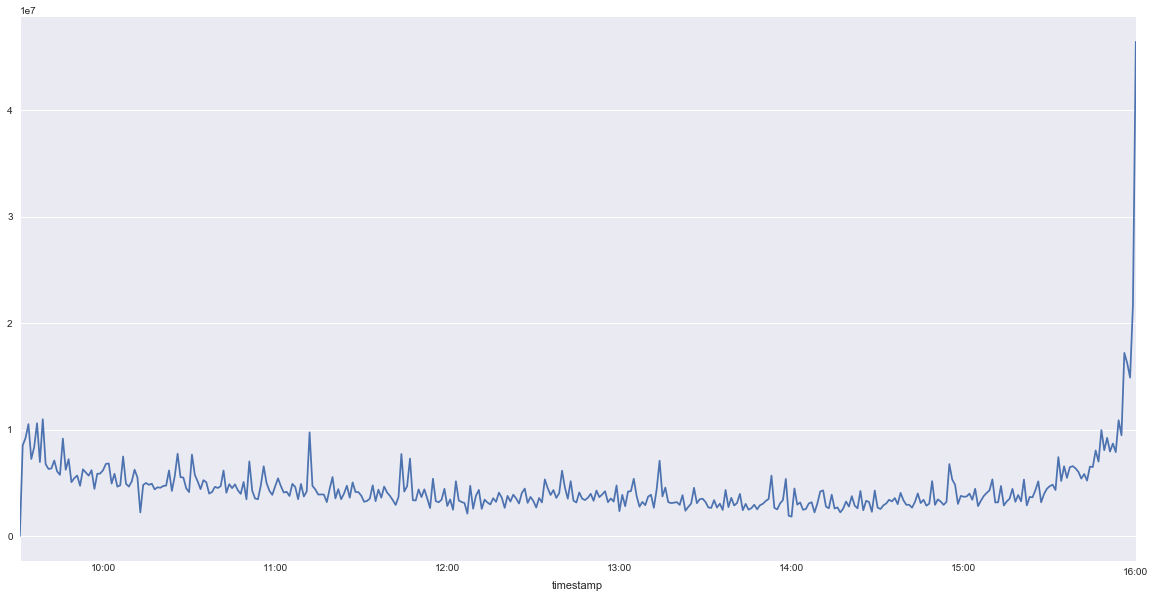

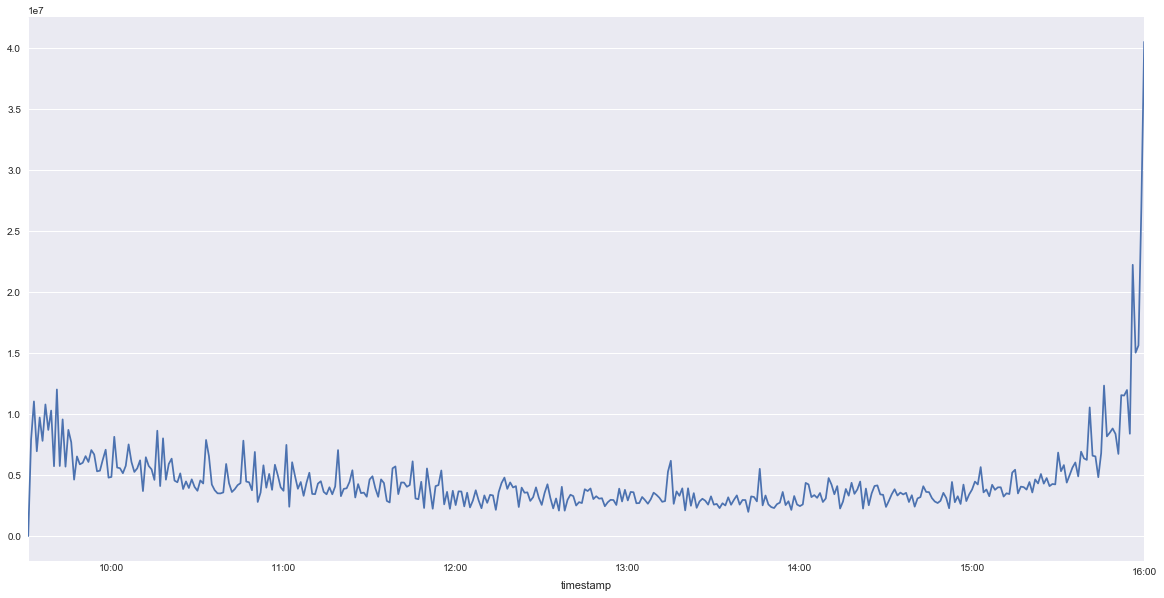

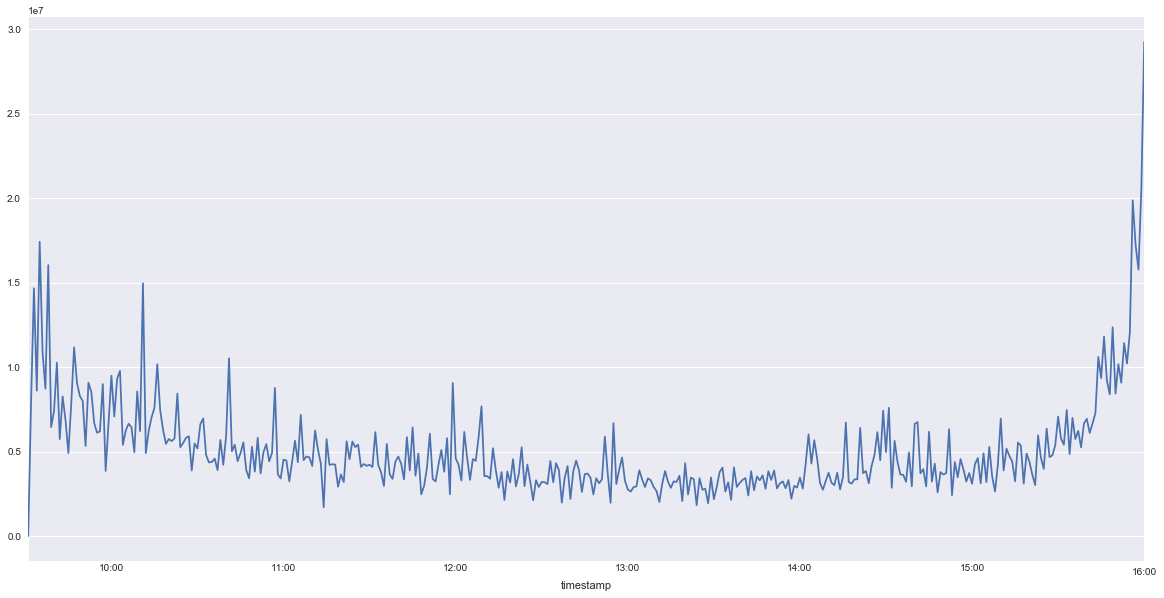

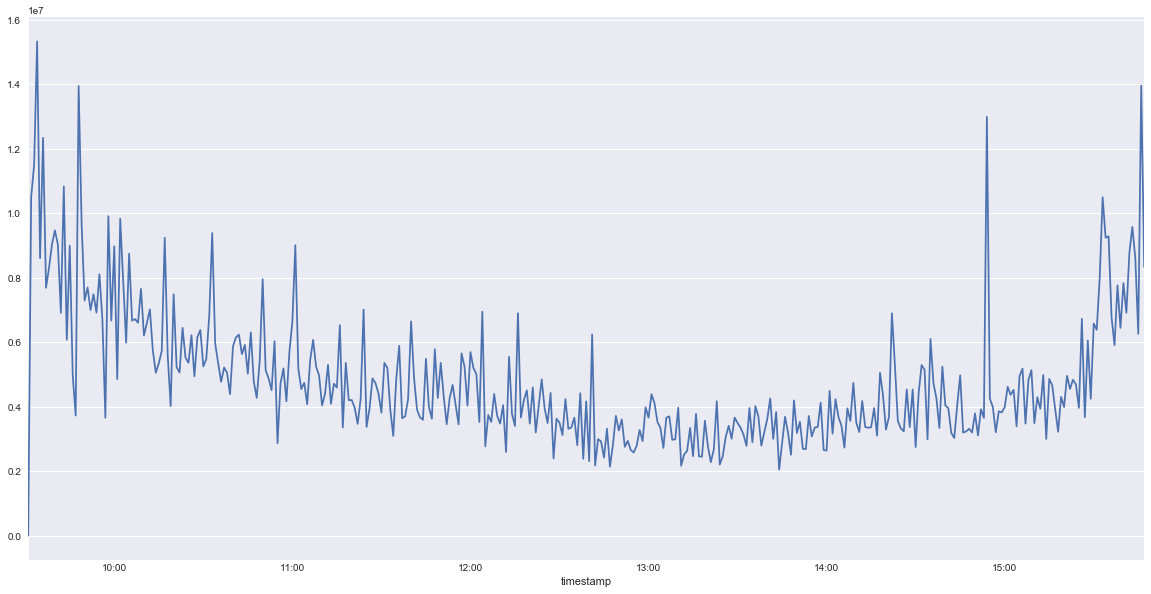

In [829]:
for date in np.unique(spx.index.date):
    spx[spx.index.date == date]['volume'].plot(figsize = (20,10))
    plt.show()

In [830]:
close_time = dt.datetime(2019,1,16,13)

curr_time = dt.datetime.now()
time_remaining = close_time - curr_time
time_remaining = time_remaining.seconds/60

iv = 0.164
strike = 2635
spot = spx.tail(1).close.values[0]
print(py_bs.black_scholes('c', spot, strike, (time_remaining/390)/365, 0.024, 0.137))
print(py_bs.black_scholes('p', spot, strike, (time_remaining/390)/(365), 0.024, 0.137))
py_greeks.delta('c', spot, strike, (time_remaining/390)/365, 0.024, 0.096)



2.18061934884e-08
17.0651687725


8.8487763601455362e-15